# Shape metrics for neural representations

This notebook demonstrates how to compute shape metrics for neural network representations proposed by Williams et al. (2021; [arXiv:2210.14739](https://arxiv.org/abs/2110.14739)).


In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import sklearn.datasets
import seaborn as sns

from netrep.metrics import LinearMetric

## The `LinearMetric` class

We provide a simple example below to show how to use our `LinearMetric` class.
This method computes a distance between two network representations (e.g. trial-averaged biological neural population recordings, or deep net activations).
Intuitively, `LinearMetric` defines a _group_ of nuisance transformations over which to optimize and compute distances between two representations.

If two networks can be perfectly aligned by some transform within this group (e.g. rotations, permutations, linear/affine transforms), then we can say that their representations are the same, and `LinearMetric` returns a distance of zero.
If, after computing an optimal alignment, there still exists disparity between the two representations, then the distance is non-zero.
See Williams et al. (2021; [arXiv:2210.14739](https://arxiv.org/abs/2110.14739)) for more details.

### Creating synthetic neural responses

We synthesize $N=2$ dimensional responses for $K=3$ networks, each responding to $M=256$ stimuli.
By construction, Network 1 and 2 will differ only by a simple random rotation in representation space, while Network 3's responses will be a random linear transform of Network 1 responses.

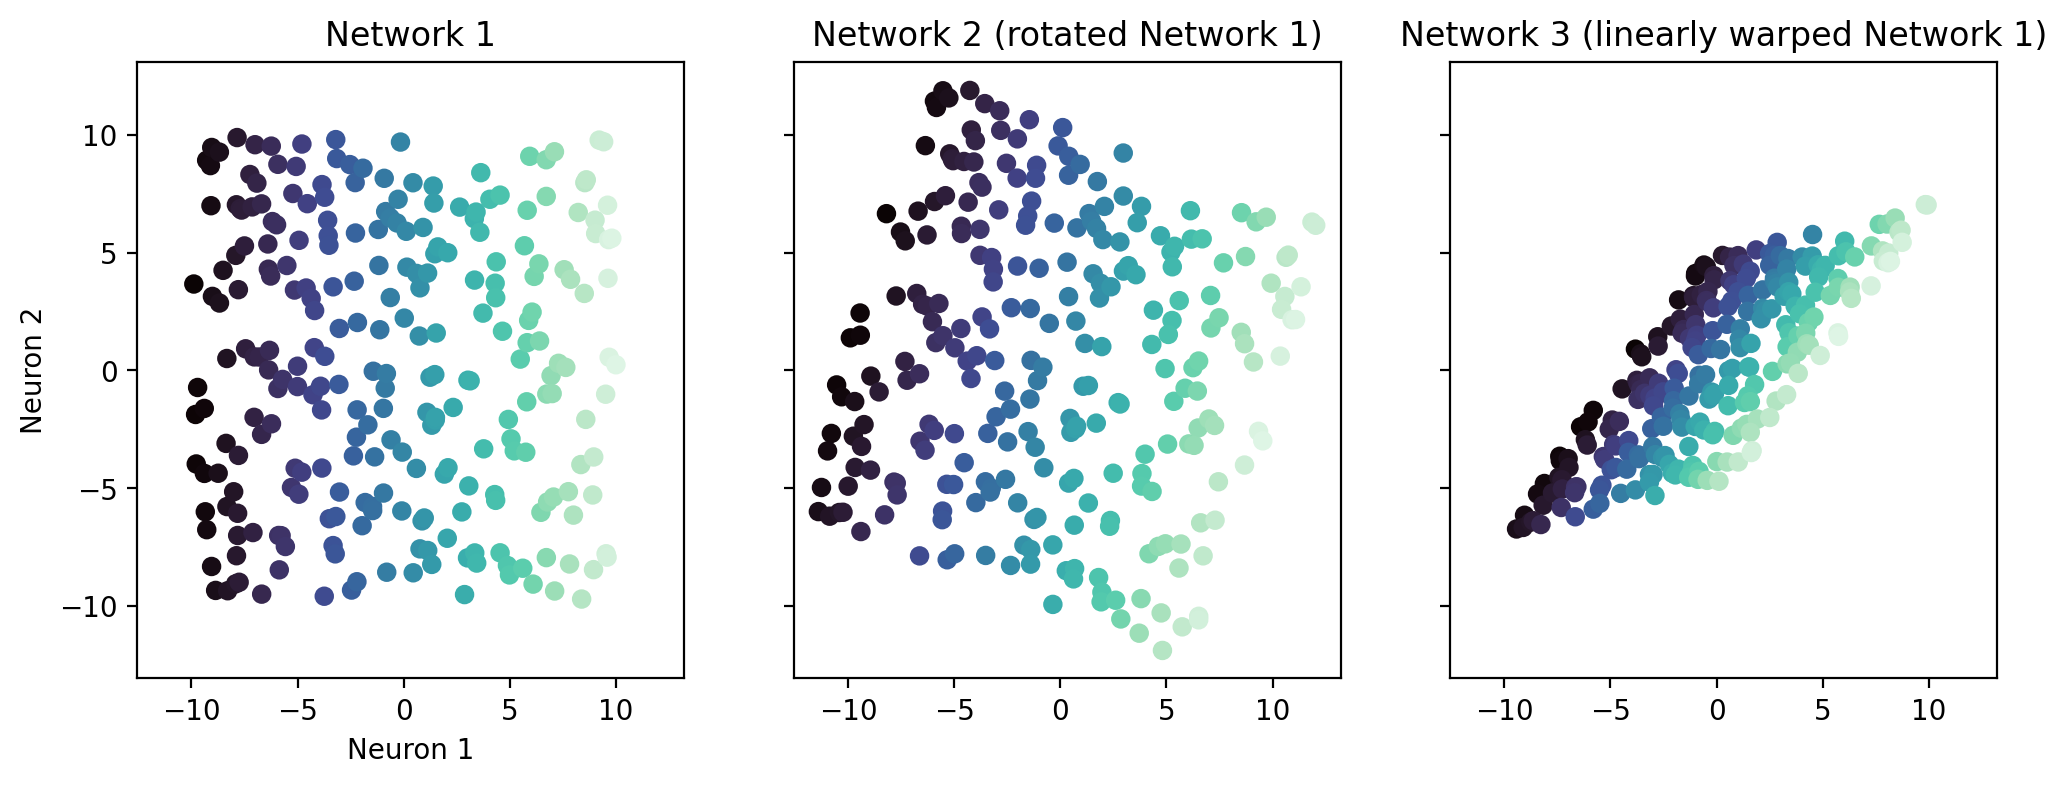

In [3]:
def rot(theta: float, X: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Helper for rotating data."""
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return X @ R.T

seed = 42069
rng = np.random.default_rng(seed)

n_classes = 256
n_features = 2

# create data
X1, _ = sklearn.datasets.make_blobs(
                                    n_samples=n_classes, 
                                    n_features=n_features, 
                                    centers=n_classes, 
                                    cluster_std=0., 
                                    shuffle=False,
                                    random_state=seed,
                                    )

X1 = X1[np.argsort(X1[:,0])] # sort X1 by x-coord for colormap
X2 = rot(rng.random()*np.pi*2, X1)  # rotate X1
X3 = X1 @ rng.standard_exponential((n_features, n_features))  # warp X1

# plot them all
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex="all", sharey="all", dpi=200)
cols = sns.color_palette("mako", n_classes)
ax[0].scatter(*X1.T, c=cols, label="1")
ax[1].scatter(*X2.T, c=cols, label="2")
ax[2].scatter(*X3.T, c=cols, label="2")

ax[0].set(xlabel="Neuron 1", ylabel="Neuron 2", title="Network 1")
ax[1].set(title="Network 2 (rotated Network 1)")
ax[2].set(title="Network 3 (linearly warped Network 1)");

The above plot shows each hypothetical network's response to each of the $M$ stimuli.
The colors denote the identity of the stimulus.

### Computing the linear shape metric

We'll split the data into train and test sets, then compute shape distances using `LinearMetric`, initialized with either $\alpha=0$ (CCA) or $\alpha=1$ (Procrustes distance).
When $\alpha=0$, the group of allowed nuissance transformations is any arbitrary linear map.
By contrast, when $\alpha=1$, the group of nuissance transformations is the set of orthogonal matrices.

Computing distances between $K$ networks requires $K \choose 2$ pairwise comparisons. 
We'll compute them manually here for clarity, but also provide simple a utility function in our library called `pairwise_distances()` that abstracts away the details.

In [4]:
# random indices for training set
idx_train = rng.choice(np.arange(n_classes), int(n_classes*.8), replace=False)

# everything left over is test set
idx_test = np.array(list(set(np.arange(n_classes)).difference(idx_train)))

X1_train, X1_test = X1[idx_train], X1[idx_test]
X2_train, X2_test = X2[idx_train], X2[idx_test]
X3_train, X3_test = X3[idx_train], X3[idx_test]

X_train = (X1_train, X2_train, X3_train)
X_test = (X1_test, X2_test, X3_test)

distmats = dict()

for alpha in (0, 1):
    distmat = np.zeros((3, 3))

    # loop through K choose 2 pairwise comparisons
    for i, j in itertools.combinations(range(3), 2):
        metric = LinearMetric(
            alpha=alpha, 
            center_columns=True,
            score_method="angular",
            )
        metric.fit(X_train[i], X_train[j])
        dist = metric.score(X_test[i], X_test[j])
        distmat[i, j] = dist
    
    distmat += distmat.T  # distance matrices are symmetric
    distmats[alpha] = distmat

### Plotting the distance matrices

By construction, the representations of Networks 1 and 2 differ only by a rotation, while Network 3 differs from Network 1 via an arbitrary linear transform.
We should therefore expect qualitatively different results using `LinearMetric()` when $\alpha=0$ vs. $\alpha=1$.
Specifically, when $\alpha=1$ (i.e. Procrustes distance allowing for only rotational alignments), the computed distance between Networks 1 and 2 should be zero while distances between Networks 1 vs 3 and 2 vs 3 should be non-zero.
When $\alpha=0$, any arbitrary linear transform is allowed in the group of nuisance transforms; thus, we should expect the distance between all networks to be zero.

The below plots of the computed distances using `LinearMetric` from above show that this is indeed the case.

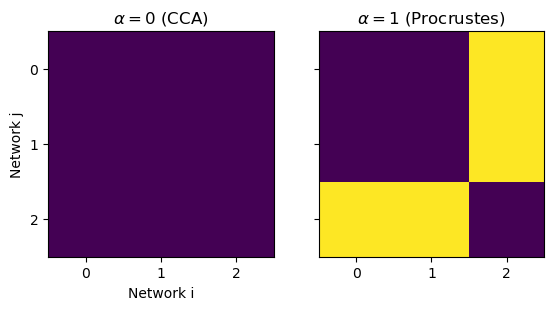

In [6]:
fig, ax = plt.subplots(1, 2, sharex="all", sharey="all")

_VMAX = np.max([distmats[0], distmats[1]])
for alpha in (0, 1):
    ax[alpha].imshow(distmats[alpha], vmin=0, vmax=_VMAX)

ax[0].set(title=r"$\alpha=0$ (CCA)")
ax[0].set(xticks=range(3), yticks=range(3))
ax[0].set(xlabel="Network i", ylabel="Network j")

ax[1].set(title=r"$\alpha=1$ (Procrustes)");

## Useful tips

### `LinearMetric` is a sklearn estimator

Since `LinearMetric` inherits scikit-learn's BaseEstimator class, we can seamlessly integrate it into any scikit-learn workflow.
Below is an example showing how to easily perform cross-validation with the metric.

In [4]:
from sklearn.model_selection import cross_validate
metric = LinearMetric(alpha=1)
results = cross_validate(metric, X1, X3, return_train_score=True, cv=10)
print(results["train_score"])  # holds 10 distance estimates between X and Y, using training data.
print(results["test_score"])   # holds 10 distance estimates between X and Y, using heldout data.

[0.46626067 0.46140001 0.46623968 0.46866604 0.47149637 0.47078356
 0.46782596 0.46504587 0.46302238 0.46197876]
[0.48806546 0.50628853 0.48546268 0.4625334  0.37655937 0.4109973
 0.47418875 0.49561857 0.50214559 0.51200611]


### Using `transform()` to align two representations

Like other scikit-learn estimators, each `LinearMetric` object has a `transform()` method, allowing us to obtain optimally aligned/fitted representations.
This makes it more apparent that Networks 1 and 2's responses are indeed the same.

[Text(0.5, 1.0, 'Network 2 Aligned')]

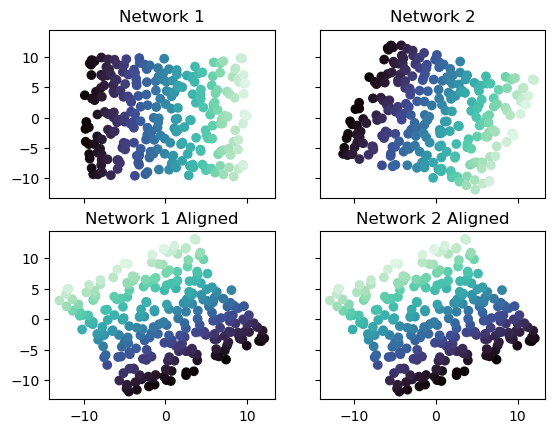

In [5]:
# Fit alignment transformations.
metric = LinearMetric(alpha=1.)
metric.fit(X1, X2)

# Apply alignment transformations.
X1_aligned, X2_aligned = metric.transform(X1, X2)

fig, ax = plt.subplots(2, 2, sharex="all", sharey="all")
ax[0,0].scatter(*X1.T, c=cols)
ax[0,1].scatter(*X2.T, c=cols)
ax[1,0].scatter(*X1_aligned.T, c=cols)
ax[1,1].scatter(*X2_aligned.T, c=cols)

ax[0,0].set(title="Network 1")
ax[0,1].set(title="Network 2")
ax[1,0].set(title="Network 1 Aligned")
ax[1,1].set(title="Network 2 Aligned")